Total vehicles generated by simulation: 15346.0
Total parked customers: 12285.0
Average parking lot occupancy (8-11:59 AM): 6.83%
Average parking lot occupancy (12-4:59 PM): 21.90%
Average parking lot occupancy (5-8 PM): 22.46%
Total fixed pricing revenue: ₹576585.0
Total lost customers due to low WTV: 19.52%
Total lost customers due to parking full: 0.0
Total lost customers due to parking full: 0.00%


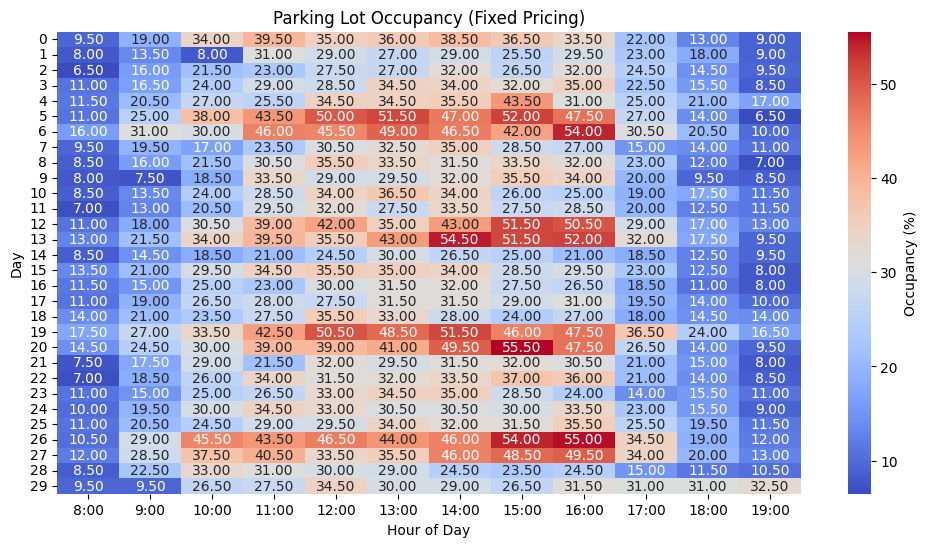

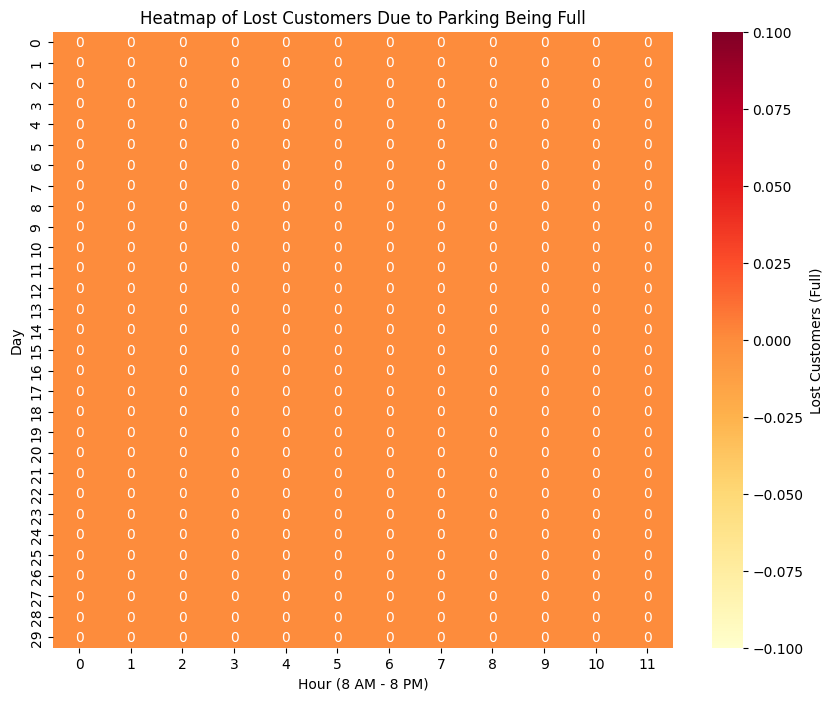

In [13]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
SIM_DURATION = 30 * 12 * 60  # 30 days, 12 hours per day (8 AM to 8 PM)
CAPACITY = 200
BASE_PRICE = 25  # Fixed price of ₹25 throughout the simulation
INITIAL_WILLINGNESS_TO_VISIT = 0.8  # Initial WTV for arrival rate

# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Monday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Tuesday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Wednesday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Thursday': [(8, 12, 15*1), (12, 17, 50*1), (17, 20, 50*1)],
    'Friday': [(8, 12, 20*1), (12, 17, 70*1), (17, 20, 80*1)],
    'Saturday': [(8, 12, 20*1), (12, 17, 70*1), (17, 20, 80*1)]
}

# Initialize data for tracking revenue, utilization, and lost customers
revenue_history_fixed = np.zeros((30, 12))  # Revenue history for fixed pricing
occupancy_history = np.zeros((30, 12))  # Occupancy history for each hour and day
lost_customers_full = np.zeros((30, 12))  # Lost customers due to parking full
total_customers_attempted = np.zeros((30, 12))  # Total attempted customers
total_arrivals = np.zeros((30, 12))  # Total arrivals
total_parked_customers = np.zeros((30, 12))  # Total parked customers
lost_customers_due_to_wtv = np.zeros((30, 12))  # Lost customers due to WTV < 0.7

def get_arrival_rate(day, hour):
    """Return the arrival rate based on the day and hour."""
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            return rate
    return 0

def update_occupancy(parking_lot, day_index, hour_index):
    """Updates the occupancy for the parking lot and records it."""
    occupancy = len(parking_lot.users) / CAPACITY * 100
    occupancy_history[day_index, hour_index] = occupancy

def get_parking_duration(previous_occupancy):
    """Determine parking duration based on previous hour's occupancy."""
    if previous_occupancy > 80:
        # Use an exponential distribution with a mean of 15 minutes
        duration = np.random.exponential(15)
        return min(duration, 60)  # Cap duration to a maximum of 30 minutes
    elif previous_occupancy < 20:
        # Use an exponential distribution with a mean of 120 minutes
        duration = np.random.exponential(120)
        return min(duration, 180)  # Cap duration to a maximum of 3 hours
    else:
        # Use an exponential distribution with a mean of 60 minutes
        return np.random.exponential(60)


def vehicle(env, parking_lot, day_index, hour_index, previous_occupancy):
    """Simulates a vehicle parking and tracks revenue."""
    global revenue_history_fixed, lost_customers_due_to_wtv, total_parked_customers

    # Track the time of parking and the fixed price
    arrival_time = env.now
    with parking_lot.request() as request:
        yield request
        if len(parking_lot.users) >= CAPACITY:
            # Increment the count of lost customers due to parking full
            lost_customers_full[day_index, hour_index] += 1
            return  # Exit the function as no parking is available

        parking_duration = get_parking_duration(previous_occupancy)  # Get parking duration based on previous occupancy
        yield env.timeout(parking_duration)
        
        # Calculate the duration of stay
        duration_in_hours = parking_duration / 60
        if duration_in_hours <= 0.5:
            # Charge ₹15 for stays less than 30 minutes
            revenue = 15
        else:
            # Charge based on the fixed hourly rate
            hours_rounded = np.ceil(duration_in_hours)
            revenue = hours_rounded * BASE_PRICE

        # Track the revenue and parked customers
        revenue_history_fixed[day_index, hour_index] += revenue
        total_parked_customers[day_index, hour_index] += 1

        # Update occupancy after vehicle leaves
        update_occupancy(parking_lot, day_index, hour_index)

def arrival_process(env, parking_lot, day, day_index):
    """Simulates the arrival process based on the day and time."""
    global lost_customers_full, total_customers_attempted, total_arrivals, occupancy_history
    
    previous_occupancy = 0

    while env.now < (day_index + 1) * 12 * 60:  # Simulate only 12 hours of the current day
        current_hour = (env.now // 60) % 12 + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
        rate = get_arrival_rate(day, current_hour)
        
        # Determine the hour index (0 to 11 for 8 AM to 8 PM)
        hour_index = int(current_hour - 8)  # Adjust index to match 0-11 range
        
        if 0 <= hour_index < 12:  # Ensure hour_index is within valid bounds
            if rate > 0:
                inter_arrival_time = np.random.exponential(60 / rate)  # Convert hourly rate to inter-arrival time
                yield env.timeout(inter_arrival_time)
                
                # Update the WTV for arrival
                if np.random.uniform() > INITIAL_WILLINGNESS_TO_VISIT:
                    # Increment the count of lost customers due to low WTV
                    lost_customers_due_to_wtv[day_index, hour_index] += 1
                else:
                    # Pass the occupancy of the previous hour to the vehicle process
                    env.process(vehicle(env, parking_lot, day_index, hour_index, previous_occupancy))
                
                # Increment total attempted customers and total arrivals
                total_customers_attempted[day_index, hour_index] += 1
                total_arrivals[day_index, hour_index] += 1

            # Update occupancy at each arrival attempt
            update_occupancy(parking_lot, day_index, hour_index)
            
            # Update previous hour's occupancy for next hour's vehicles
            if hour_index == 11:  # Last hour of the day
                previous_occupancy = occupancy_history[day_index, 0]  # Wrap around to first hour of the next day
            else:
                previous_occupancy = occupancy_history[day_index, hour_index + 1]
        else:
            yield env.timeout(1)  # Wait for 1 minute if no arrival

def run_simulation():
    """Runs the simulation for 30 days with fixed pricing."""
    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=CAPACITY)

    for day_index in range(30):
        day_name = list(ARRIVAL_RATES.keys())[day_index % 7]  # Cycle through days of the week
        env.process(arrival_process(env, parking_lot, day_name, day_index))

        # Simulate 12 hours of the current day
        env.run(until=(day_index + 1) * 12 * 60)

    # Calculate and print the results
    average_occupancy_morning = np.mean(total_parked_customers[:, 0:4], axis=1) / CAPACITY * 100  # 8-11:59 AM
    average_occupancy_afternoon = np.mean(total_parked_customers[:, 4:8], axis=1) / CAPACITY * 100  # 12-4:59 PM
    average_occupancy_evening = np.mean(total_parked_customers[:, 8:12], axis=1) / CAPACITY * 100  # 5-8 PM

    avg_occupancy_morning = np.mean(average_occupancy_morning)
    avg_occupancy_afternoon = np.mean(average_occupancy_afternoon)
    avg_occupancy_evening = np.mean(average_occupancy_evening)

    total_parked_customers_sum = np.sum(total_parked_customers)
    total_vehicles_simulated = np.sum(total_arrivals)
    total_revenue_fixed = np.sum(revenue_history_fixed)  # Fixed pricing revenue

    percentage_lost_due_to_wtv = (np.sum(lost_customers_due_to_wtv) / total_vehicles_simulated) * 100
    percentage_lost_customers_due_to_full = (np.sum(lost_customers_full) / total_vehicles_simulated) * 100

    # Print results
    print(f"Total vehicles generated by simulation: {total_vehicles_simulated}")
    print(f"Total parked customers: {total_parked_customers_sum}")
    print(f"Average parking lot occupancy (8-11:59 AM): {avg_occupancy_morning:.2f}%")
    print(f"Average parking lot occupancy (12-4:59 PM): {avg_occupancy_afternoon:.2f}%")
    print(f"Average parking lot occupancy (5-8 PM): {avg_occupancy_evening:.2f}%")
    print(f"Total fixed pricing revenue: ₹{total_revenue_fixed}")
    print(f"Total lost customers due to low WTV: {percentage_lost_due_to_wtv:.2f}%")
    print(f"Total lost customers due to parking full: {np.sum(lost_customers_full)}")
    print(f"Total lost customers due to parking full: {percentage_lost_customers_due_to_full:.2f}%")

    # Heatmap for occupancy
    plt.figure(figsize=(12, 6))
    sns.heatmap(occupancy_history, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Occupancy (%)'})
    plt.title("Parking Lot Occupancy (Fixed Pricing)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day")
    plt.xticks(ticks=np.arange(12) + 0.5, labels=[f"{hour}:00" for hour in range(8, 20)])
    plt.show()

    # Generate a heatmap of lost customers due to parking being full
    plt.figure(figsize=(10, 8))
    sns.heatmap(lost_customers_full, cmap="YlOrRd", annot=True, fmt=".0f", cbar_kws={'label': 'Lost Customers (Full)'})
    plt.title("Heatmap of Lost Customers Due to Parking Being Full")
    plt.xlabel("Hour (8 AM - 8 PM)")
    plt.ylabel("Day")
    plt.show()

# Run the simulation
run_simulation()
